# Capstone Project - The Battle of the Neighborhoods
## Coursera/IBM


## Introduction \ Business Problem

This project is targeted to stakeholders wishing to understand whether there are the conditions to open a __new Japanese restaurant__ in __London, UK__. Data science is needed to investigate this issue since, according to the Office for National Statistics (2015) there are already around **18110** restaurants in the city, including take away food shops and mobile food stands. 
 
After discussions with stakeholders, a few conditions to identify potential neighborhoods were defined: 
 
 * not too crowded in terms of number of restaurants
 * with no or very few Japanese restaurants
 * as close as possible to the city center of London
 
More in detail,the stakeholders would like to open a restaurant in an area not farther than about 8 kilometers from the city centre but the closer it is the better. Other conditions that were defined were the absence of other Japanese restaurants in a radius of 350 m and with very few restaurants of different type in the same radius. Data analysis and machine learning will be applied to find out whether these conditions exists. If they would, the potential neighborhood will be discussed in terms of their characteristics to allow the stakeholders to take the best decision.

## Data

* The first data I will use are the coordinates of the city center of London as retrieved using __GeoPy__. Then, I will create a __grid of locations__ (500 m spacing) with the city centre as center of the grid. Each location will represent the center of a circular area of 350 m radius that I will use as neighborhood.
* I will identify the __geographical coordinates__ of all these neighborhoods using the __GeoPy client__. Whenever needed, I will be using GeoPy also for reverse geocoding, i.e. to get the address information from geographical coordinates. The  distance between each neighborhood and the city centre of London will be also calculated using the module **pyproj** that allows to change the coordinate system (e.g. from degrees to meters) making easy to compute the distance between two geographical locations. 
* Finally, the __Foursquare API__ will be used to identify the number of restaurants and particularly Japanese restaurants in each neighborhood. This will allow to identify the neighborhoods less crowded in terms of restaurants.

### Importing needed libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image
from geopy.geocoders import Nominatim
import pyproj
import folium
import requests
from pandas.io.json import json_normalize
import time

### Getting coordinates of London city centre

In [4]:
address = 'London, UK'
geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address, timeout=10)
centre_latitude = location.latitude
centre_longitude = location.longitude
print('The city center of London has latitude', centre_latitude, 'and longitude', centre_longitude)

The city center of London has latitude 51.5073219 and longitude -0.1276474


Now, I convert the coordinates of London city center to meters.

In [5]:
proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
proj_xy = pyproj.Proj(proj="utm", zone='30U', datum='WGS84')
xy_london = pyproj.transform(proj_latlon, proj_xy, centre_longitude, centre_latitude)

centre_long_m = xy_london[0]
centre_lat_m = xy_london[1]
print('The city center of London has latitude', centre_lat_m, 'm and longitude', centre_long_m, 'm')

The city center of London has latitude 5710155.49053811 m and longitude 699327.1629885819 m


### Creating a grid of coordinate locations around London city centre

Now, I create a square grid of 15 km per side centered at the coordinates of the city center of London with new locations every 500 meters 

In [6]:
side = 15000
diameter = 500
n_samples = int(side/diameter)
n_samples_x_row = n_samples+1
n_samples_grid = n_samples_x_row**2

x = np.linspace((centre_long_m-(n_samples/2)*diameter), (centre_long_m+(n_samples/2)*diameter), n_samples_x_row)
y = np.linspace((centre_lat_m-(n_samples/2)*diameter), (centre_lat_m+(n_samples/2)*diameter), n_samples_x_row)
x1,y1 = np.meshgrid(x,y)

In [7]:
long_m = []
lat_m = []

for row in x1:
  for col in row:
    long_m.append(col)
    
for row in y1:
  for col in row:
    lat_m.append(col)

Now, I convert the coordinates from UTC (meters) to degrees to allow data retrieval from FourSquare. I noticed that the conversion of the coordinate system introduces a small error in the coordinates. Hence, the following code also adjusts for this error.

In [8]:
proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
proj_xy = pyproj.Proj(proj="utm", zone='30U', datum='WGS84')

xy_deg = pyproj.transform(proj_xy, proj_latlon, long_m, lat_m)
long_deg = xy_deg[0]
lat_deg = xy_deg[1]

#removing the conversion error
lat_deg=lat_deg[0::n_samples_x_row]
lat_deg=[item for item in lat_deg[0:n_samples_x_row] for i in range(n_samples_x_row)]
long_deg=long_deg[0:n_samples_x_row]*n_samples_x_row
long_deg=long_deg*n_samples_x_row
long_deg=long_deg[0:n_samples_x_row*n_samples_x_row]
print(lat_deg,long_deg)

[51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44255750149859, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818561125, 51.44704818

Let's visualize a first map of London including the city centre and location of the neighborhoods

In [10]:
map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=10)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)
for lat, lon in zip(lat_deg, long_deg):
    folium.Circle([lat, lon], radius=250, color='blue', fill=False).add_to(map_london)
map_london

<img src="files/img/fig1.png">

The city centre is a bit offset because of the adjustment I had to do. Let's recompute it.

In [56]:
centered_circle = int(n_samples_grid/2)
centre_latitude = lat_deg[centered_circle]
centre_longitude = long_deg[centered_circle]
print(centre_latitude, centre_longitude)

51.509917292420766 -0.13187770068924268


... and print the map again! I also change the radius to avoid neglected areas. This will make data retrieval a bit redundant but I prefer this issue than having not considered entire streets.

In [ ]:
map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=10)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)
for lat, lon in zip(lat_deg, long_deg):
    folium.Circle([lat, lon], radius=350, color='blue', fill=False).add_to(map_london)
map_london

<img src="files/img/fig2.png">

Looks much better now!

### Calculating distances of each neighborhood to London's city centre

First, I convert the coordinates of London city centre to a coordinate system that makes easier to calculate distances

In [58]:
xy_london = pyproj.transform(proj_latlon, proj_xy, centre_longitude, centre_latitude)
print(xy_london[0], xy_london[1])

699022.3406160263 5710432.534145423


Ok. Now, I loop through the coordinate matrices to get the distance from each point to the city centre of London.

In [ ]:
distances = []

for i in range(len(long_m)):
    distances.append(np.sqrt((long_m[i]-xy_london[0])**2 + (lat_m[i]-xy_london[1])**2))
    print(distances[i])

### Retrieving the address of each point

In [ ]:
address = []

for lat,lon in zip(lat_deg, long_deg):
    stringa = str(lat)+', '+str(lon)
    location = geolocator.reverse(stringa, timeout=10)
    address.append(location.address)
    
print(address)    

I save the data into a pandas dataframe

In [77]:
data = {'Address': address, 'Latitude': lat_deg, 'Longitude': long_deg, 'Latitude_m': lat_m, 
        'Longitude_m': long_m, 'Distance_to_center': distances}
df = pd.DataFrame(data=data)
df.head()

,Address,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center
0,"Kingston Road, Roehampton, London Borough of W...",51.442558,-0.239658,5.702655e+06,691827.162989,10594.951079
1,"Windmill Ride, Roehampton, London Borough of W...",51.442558,-0.232472,5.702655e+06,692327.162989,10261.959400
2,"Wimbledon Park Side, Southfields, London Borou...",51.442558,-0.225286,5.702655e+06,692827.162989,9942.969029
3,"Radley Lodge, 25, Inner Park Road, Southfields...",51.442558,-0.218101,5.702655e+06,693327.162989,9639.370077
4,"Ambleside, 1-57, Albert Drive, Southfields, Lo...",51.442558,-0.210915,5.702655e+06,693827.162989,9352.661538


Ok. I filter the locations to be within 8000 meters from the city centre

In [78]:
df = df[df['Distance_to_center'] <= 8000]
df.reset_index(drop=True,inplace=True)
df.describe()

,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center
count,791.000000,791.000000,7.910000e+02,791.000000,791.000000
mean,51.511592,-0.134941,5.710342e+06,699114.141497,5292.502531
std,0.035759,0.056928,3.981483e+03,3961.660545,1875.520064
min,51.442558,-0.239658,5.702655e+06,691827.162989,296.317160
25%,51.482973,-0.182173,5.707155e+06,695827.162989,3944.666344
50%,51.509917,-0.131878,5.710155e+06,699327.162989,5650.788060
75%,51.541352,-0.088770,5.713655e+06,702327.162989,6838.469743
max,51.577276,-0.024114,5.717655e+06,706827.162989,7992.736140


Good. There are 791 points left. Let's visualize them.

In [ ]:
map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=10)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)
for lat, lon in zip(df['Latitude'], df['Longitude']):
    folium.Circle([lat, lon], radius=350, color='blue', fill=False).add_to(map_london)
map_london

<img src="files/img/fig3.png">

### Getting data from Foursquare

Next, I am going to start utilizing the Foursquare API to explore the locations and segment them.

In [66]:
CLIENT_ID = '15W3LRQB4TVR3MSWDSUOWDMPESFXJZFNTMTNIGCHDGSGEARW' # your Foursquare ID
CLIENT_SECRET = 'D5M0YFVA1ZKYMJRPB00UDUAXYN1CSR5CTMJ5V4D2QWAGFMAD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 15W3LRQB4TVR3MSWDSUOWDMPESFXJZFNTMTNIGCHDGSGEARW
CLIENT_SECRET:D5M0YFVA1ZKYMJRPB00UDUAXYN1CSR5CTMJ5V4D2QWAGFMAD


In [245]:
def count_japanese(dataframe,japanese_categories):
    n_japanese = 0
    
    for i in range(dataframe.shape[0]):
        a=dataframe['categories'][i]
        if a:
            cat_id = a[0]['id']
            for ids in japanese_categories:
                if ids == cat_id:
                    n_japanese = n_japanese + 1            
        
    return n_japanese


def check_japanese(dataframe,japanese_categories):
    isjap = []
    
    for i in range(dataframe.shape[0]):
        a=dataframe['categories'][i]
        if a:
            cat_id = a[0]['id']
            if japanese_categories.count(cat_id)==1:
                isjap.append('True')
            elif japanese_categories.count(cat_id)==0:
                isjap.append('False')
        elif not a:
            isjap.append('False')
            
    return isjap

In [290]:
search_query = 'restaurant'

japanese_categories = ['4bf58dd8d48988d111941735','55a59bace4b013909087cb0c','55a59bace4b013909087cb30',
                       '55a59bace4b013909087cb21','55a59bace4b013909087cb06','55a59bace4b013909087cb1b',
                      '55a59bace4b013909087cb1e','55a59bace4b013909087cb18','55a59bace4b013909087cb24',
                      '55a59bace4b013909087cb15','55a59bace4b013909087cb27','55a59bace4b013909087cb12',
                      '4bf58dd8d48988d1d2941735','55a59bace4b013909087cb2d','55a59a31e4b013909087cb00',
                      '55a59af1e4b013909087cb03','55a59bace4b013909087cb2a','55a59bace4b013909087cb0f',
                      '55a59bace4b013909087cb33','55a59bace4b013909087cb09','55a59bace4b013909087cb36']
radius = 350
LIMIT = 100
seconds = 8  #introduce a delay to each API call to avoid reaching hourly limit of requests

n_restaurants = []
n_japanese = []
is_japanese = []
dataframe = pd.DataFrame()

for i in range(df.shape[0]): 
    print(' .',end='')
    latitude = df['Latitude'][i]
    longitude = df['Longitude'] [i]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = ''
    
    while results == '':
        try:
            results = requests.get(url,time.sleep(seconds)).json()
            break
        except:
            print("Connection refused by the server..")
            print("...")
            time.sleep(5)
            print("...")
            continue    
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframenew = json_normalize(venues)
    is_jap = check_japanese(dataframenew, japanese_categories)
    is_japanese.append(is_jap)
    dataframe = dataframe.append(dataframenew,ignore_index=True)

print('Done!')
#remove empty sublists
is_japanese = [x for x in is_japanese if x != []]
#flattening list of lists
is_japanese = [item for sublist in is_japanese for item in sublist]

dataframe['is_japanese'] = is_japanese
dataframe.head()

dataframe.to_csv('london_restaurants_raw.csv',mode='a',header=False)

 .

C:\Users\fabrizio.leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


 . . . . . . . . . . . . . . .Done!


Good. After an offline cleaning of the file because of the inconsistent formatting of the data, I import the csv into a dataframe

In [359]:
dataframe = pd.read_csv('london_restaurants_cleaned.csv',sep=',')
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,is_japanese
0,59395b25a6ec98688abdfd95,Curveball Restaurant & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1591257271,False,16 Hildreth Street,51.444472,-0.151164,"[{'label': 'display', 'lat': 51.44447225542944...",264,SW12 9RQ,GB,Balham,Greater London,United Kingdom,"['16 Hildreth Street', 'Balham', 'Greater Lond...",False
1,4ad63980f964a520d70521e3,The Exhibit,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1591257271,False,12 Balham Station Rd.,51.443153,-0.151080,"[{'label': 'display', 'lat': 51.44315329511457...",176,SW12 9SG,GB,Balham,Greater London,United Kingdom,"['12 Balham Station Rd.', 'Balham', 'Greater L...",False
2,4ad63980f964a520d70521e3,The Exhibit,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1591257280,False,12 Balham Station Rd.,51.443153,-0.151080,"[{'label': 'display', 'lat': 51.44315329511457...",341,SW12 9SG,GB,Balham,Greater London,United Kingdom,"['12 Balham Station Rd.', 'Balham', 'Greater L...",False
3,4fdf361fe4b08aca4a337abf,Asafo Restaurant,"[{'id': '4bf58dd8d48988d1c8941735', 'name': 'A...",v-1591257478,False,60 Morrish Rd. Brixton Hill,51.445277,-0.124760,"[{'label': 'display', 'lat': 51.44527650103059...",302,SW2 4EG,GB,London,Greater London,United Kingdom,"['60 Morrish Rd. (Brixton Hill)', 'London', 'G...",False
4,4cbf530db6c4224b9272f294,Troy Barbecue,"[{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'T...",v-1591257478,False,96 Streatham Hill,51.442128,-0.124948,"[{'label': 'display', 'lat': 51.44212797679391...",50,SW2 4RD,GB,Streatham,Greater London,United Kingdom,"['96 Streatham Hill', 'Streatham', 'Greater Lo...",False


Ok. I remove some columns I do not need and I rename some of the others.

In [360]:
dataframe.drop(['id','referralId','hasPerk','location.address',
                'location.labeledLatLngs','location.distance','location.postalCode',
                'location.cc','location.city','location.state','location.country',
                'location.formattedAddress'],axis=1,inplace=True)

dataframe.rename(columns={'name':'Name_restaurant','categories':'Categories',
                          'location.lat':'Latitude_restaurant','location.lng':'Longitude_restaurant',
                          } ,inplace=True)

More importantly, since I retrieved data from Foursquare using partially overlapping areas, I need to remove also duplicates.

In [361]:
dataframe.drop_duplicates(keep='first',inplace=True)
dataframe.reset_index(drop=True,inplace=True)
dataframe.head()

,Name_restaurant,Categories,Latitude_restaurant,Longitude_restaurant,is_japanese
0,Curveball Restaurant & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",51.444472,-0.151164,False
1,The Exhibit,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",51.443153,-0.151080,False
2,Asafo Restaurant,"[{'id': '4bf58dd8d48988d1c8941735', 'name': 'A...",51.445277,-0.124760,False
3,Troy Barbecue,"[{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'T...",51.442128,-0.124948,False
4,Bar 61,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",51.440090,-0.125644,False


Looking good. Let's visualize where are the restaurants and japanese restaurants within 8000 meters from the city center according to Foursquare info!

In [ ]:
map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=10)
for lat, lon, jap in zip(dataframe['Latitude_restaurant'], dataframe['Longitude_restaurant'], dataframe['is_japanese']):
    if jap == False:
        folium.Circle([lat, lon], radius=5, color='blue', fill=False).add_to(map_london)
    elif jap == True:
        folium.Circle([lat, lon], radius=5, color='red', fill=False).add_to(map_london)
map_london

<img src="files/img/fig4.png">

Japanese restaurants are shown in red circles, the other in blue circles. It does not look like there are too many japanese restaurants in London. As expected, there are more restaurants close to the city centre and they get progressively less dense as the distance from  the centre increases.

## Methodology

The following steps will be performing some __basic statistics__ measuring __density of restaurants and japanese restaurants__. I will start performing these stats considering all the neighborhoods within 8 km from the city centre. Then, I will investigate how these statistics change as a function of the distance from the city centre. 
Then, I will perform a cluster analysis of the neighborhoods using __k-means__. The input of this analysis will be the distance from the city center, the number of restaurants and the number of japanese restaurants. The purpose of this analysis will be to quickly identify clusters of neighborhoods which minimize the distance from the city centre, the number of restaurants and the number of japanese restaurants. Finally, I will select a sample of neighborhoods from the best clusters as a final sampling of candidate locations.

## Results and Discussion

In [363]:
print('There are', dataframe.shape[0], 'restaurants within 8 km from the city centre')
perc_jap = (len(dataframe[dataframe['is_japanese']==True]))/dataframe.shape[0]
print(len(dataframe[dataframe['is_japanese']==True]), 'of these are japanese restaurants')
print(str('%.3f' % perc_jap)+'%', 'of all restaurants are japanese restaurants')


There are 1315 restaurants within 8 km from the city centre
33 of these are japanese restaurants
0.025% of all restaurants are japanese restaurants


Let's see how do these stats change as a function of the distance from the city centre. To do so, I first need to convert the coordinates of the restaurant locations to the UTC system, then I have to calculate the distance from the city centre and, finally, add all this information to the restaurant dataframe. 

In [364]:
# I start converting coordinates to meters
long_data=dataframe['Longitude_restaurant'].to_list()
lat_data=dataframe['Latitude_restaurant'].to_list()

xy_restaurants = pyproj.transform(proj_latlon, proj_xy, long_data, lat_data)

# Then, I calculate the distance of each restaurant to the city centre
distances = []

for i in range(len(long_data)):
    distances.append(np.sqrt((xy_restaurants[0][i]-xy_london[0])**2 + (xy_restaurants[1][i]-xy_london[1])**2))
    
#Add info into the restaurant dataframe
dataframe['Latitude_restaurant_UTC'] = xy_restaurants[1]
dataframe['Longitude_restaurant_UTC'] = xy_restaurants[0]
dataframe['Distance_restaurant_to_center'] = distances

dataframe.head()

,Name_restaurant,Categories,Latitude_restaurant,Longitude_restaurant,is_japanese,Latitude_restaurant_UTC,Longitude_restaurant_UTC,Distance_restaurant_to_center
0,Curveball Restaurant & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",51.444472,-0.151164,False,5.703104e+06,697967.579731,7404.125566
1,The Exhibit,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",51.443153,-0.151080,False,5.702958e+06,697979.113196,7547.475701
2,Asafo Restaurant,"[{'id': '4bf58dd8d48988d1c8941735', 'name': 'A...",51.445277,-0.124760,False,5.703265e+06,699798.554018,7209.383506
3,Troy Barbecue,"[{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'T...",51.442128,-0.124948,False,5.702914e+06,699799.240509,7558.079731
4,Bar 61,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",51.440090,-0.125644,False,5.702686e+06,699759.747413,7781.588344


I move the column 'is_japanese' to the last position

In [365]:
dataframe = dataframe[['Name_restaurant','Categories','Latitude_restaurant','Longitude_restaurant','Latitude_restaurant_UTC',
                      'Longitude_restaurant_UTC','Distance_restaurant_to_center','is_japanese']]
dataframe.head()

,Name_restaurant,Categories,Latitude_restaurant,Longitude_restaurant,Latitude_restaurant_UTC,Longitude_restaurant_UTC,Distance_restaurant_to_center,is_japanese
0,Curveball Restaurant & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",51.444472,-0.151164,5.703104e+06,697967.579731,7404.125566,False
1,The Exhibit,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",51.443153,-0.151080,5.702958e+06,697979.113196,7547.475701,False
2,Asafo Restaurant,"[{'id': '4bf58dd8d48988d1c8941735', 'name': 'A...",51.445277,-0.124760,5.703265e+06,699798.554018,7209.383506,False
3,Troy Barbecue,"[{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'T...",51.442128,-0.124948,5.702914e+06,699799.240509,7558.079731,False
4,Bar 61,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",51.440090,-0.125644,5.702686e+06,699759.747413,7781.588344,False


Ok. I now consider three concentric areas to find out how the stats change with distance to center. The upper limit is still 8000 meters to center. 

In [366]:
area_limits = np.linspace(0,8000,4)
print('Area limits are:', area_limits)
df1 = dataframe[(dataframe['Distance_restaurant_to_center'] < area_limits[1]) ]
df2 = dataframe[(dataframe['Distance_restaurant_to_center'] >= area_limits[1]) & (dataframe['Distance_restaurant_to_center'] < area_limits[2]) ]
df3 = dataframe[(dataframe['Distance_restaurant_to_center'] >= area_limits[2]) ]

Area limits are: [   0.         2666.66666667 5333.33333333 8000.        ]


First, I consider the concentric area within 2667 meters from the city centre

In [367]:
print('There are', df1.shape[0], 'restaurants within 2667 m from the city centre')
perc_jap = (len(df1[df1['is_japanese']==True]))/df1.shape[0]
print(len(df1[df1['is_japanese']==True]), 'of these are japanese restaurants')
print(str('%.3f' % perc_jap)+'%', 'of all restaurants are japanese restaurants')

There are 522 restaurants within 2667 m from the city centre
21 of these are japanese restaurants
0.040% of all restaurants are japanese restaurants


I now consider the area between 2667 and 5333 meters from the city centre.

In [368]:
print('There are', df2.shape[0], 'restaurants in the area comprised between 2667 and 5333 m from the city centre')
perc_jap = (len(df2[df2['is_japanese']==True]))/df2.shape[0]
print(len(df2[df2['is_japanese']==True]), 'of these are japanese restaurants')
print(str('%.3f' % perc_jap)+'%', 'of all restaurants are japanese restaurants')

There are 477 restaurants in the area comprised between 2667 and 5333 m from the city centre
10 of these are japanese restaurants
0.021% of all restaurants are japanese restaurants


Finally, I consider the more distant area (> 5333 m)

In [369]:
print('There are', df3.shape[0], 'restaurants in the area comprised between 5333 and 8000 m from the city centre')
perc_jap = (len(df3[df3['is_japanese']==True]))/df3.shape[0]
print(len(df3[df3['is_japanese']==True]), 'of these are japanese restaurants')
print(str('%.3f' % perc_jap)+'%', 'of all restaurants are japanese restaurants')

There are 316 restaurants in the area comprised between 5333 and 8000 m from the city centre
2 of these are japanese restaurants
0.006% of all restaurants are japanese restaurants


As expected, the number of restaurants decline with increasing of the distance from the city centre and japanese restaurants number declines even more (from 0.04 to 0.006% of the total).

For the final part of my analysis, I want to consider again the circular neighborhoods I defined at the beginning of the project. In particular, I want to calculate the number of restaurants and the number of japanese restaurants for each circular area with radius 350 m.

In [ ]:
def count_restaurants(df,dataframe,index):
    n_rest = 0
    n_jap = 0
    for i in range(dataframe.shape[0]):
        dist=np.sqrt((dataframe['Latitude_restaurant_UTC'][i]-df['Latitude_m'][index])**2 + (dataframe['Longitude_restaurant_UTC'][i]-df['Longitude_m'][index])**2)
        #print(dist)
        if dist <= 350:
            n_rest = n_rest + 1
            if dataframe['is_japanese'][i]==True:
                n_jap = n_jap + 1
    
    return n_rest, n_jap


n_restaurants = []
n_japanese = []

for neigh in range(df.shape[0]):
    n_rest, n_jap = count_restaurants(df,dataframe,neigh)
    n_restaurants.append(n_rest)
    n_japanese.append(n_jap)
            
print(n_restaurants,n_japanese)

Good. I save this info into the neighborhood dataframe

In [389]:
df['N_restaurants'] = n_restaurants
df['N_japanese'] = n_japanese
df.head()

,Address,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center,N_restaurants,N_japanese
0,"Sarsfeld Road, Tooting Graveney, Upper Tooting...",51.442558,-0.160618,5.702655e+06,697327.162989,7959.650398,0,0
1,"5, Balham High Road, Balham, London Borough of...",51.442558,-0.153432,5.702655e+06,697827.162989,7868.345241,1,0
2,"65, Fernlea Road, London Borough of Lambeth, L...",51.442558,-0.146247,5.702655e+06,698327.162989,7808.052203,0,0
3,"20, Glenfield Road, Abbeville Village, London ...",51.442558,-0.139063,5.702655e+06,698827.162989,7779.492373,0,0
4,"Kirkstall Road, Streatham Hill, London Borough...",51.442558,-0.131878,5.702655e+06,699327.162989,7783.015094,0,0


### Clustering neighborhoods

I am finally ready to perform a cluster analysis on neighborhoods. The goal of this analysis is to identify cluster of neighborhoods that are close to the city centre and with little or no restaurants and japanese restaurants in particular.

### Normalizing data for clustering

In [394]:
X = df.values[:,5:]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 1.42298419, -0.51018021, -0.19191097],
       [ 1.37427081, -0.30636579, -0.19191097],
       [ 1.3421031 , -0.51018021, -0.19191097],
       ...,
       [ 1.22137881, -0.51018021, -0.19191097],
       [ 1.31029192, -0.51018021, -0.19191097],
       [ 1.41415795, -0.51018021, -0.19191097]])

### Finding the optimal K for clustering

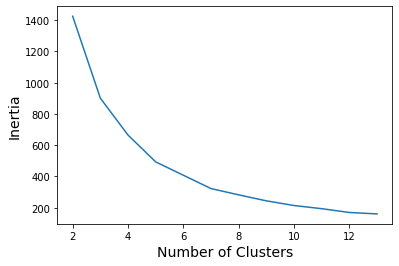

In [398]:
max_clusters = 14
inertia_values = []
for n in range(2,max_clusters):
    k_means = KMeans(init='k-means++', n_clusters=n)
    k_means.fit(cluster_dataset)
    inertia_values.append(k_means.inertia_)
    
plt.plot(range(2,max_clusters),inertia_values)
plt.xlabel('Number of Clusters',fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()

Ok. I select 5 clusters as a good K.

Lets apply kmeans to the dataset and have a look at the generated labels.

In [399]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 1 1 1 1 1
 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 4 0 4 0 4 3 0 4 0
 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 4 4 0 0 3 3 3 0 0 0 4 0 4 4 4 0 4
 4 4 4 4 1 1 1 1 1 1 1 1 1 4 4 0 0 4 4 2 3 4 0 0 0 4 0 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 0 1 4 4 4 0 4 4 3 0 3 4 4 4 3 0 0 4 0 0 4 4 4 4 1 1 1 1 1 1 1 1
 1 4 4 4 0 4 4 4 4 2 3 3 0 0 0 0 0 0 0 4 4 4 4 1 1 1 1 1 1 1 1 1 4 4 0 0 0
 4 0 0 3 3 2 2 0 4 0 0 0 3 3 4 4 4 1 1 1 1 1 1 1 1 1 4 4 0 0 0 0 0 2 2 0 2
 2 0 4 3 3 0 0 0 4 4 4 1 1 1 1 1 1 1 1 1 4 4 4 4 4 0 0 0 0 0 3 0 3 0 0 0 4
 0 0 0 4 4 0 1 1 1 1 1 1 

I assign the labels to each row in the dataframe

In [400]:
df['Cluster'] = labels
df.head()

,Address,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center,N_restaurants,N_japanese,Cluster
0,"Sarsfeld Road, Tooting Graveney, Upper Tooting...",51.442558,-0.160618,5.702655e+06,697327.162989,7959.650398,0,0,1
1,"5, Balham High Road, Balham, London Borough of...",51.442558,-0.153432,5.702655e+06,697827.162989,7868.345241,1,0,1
2,"65, Fernlea Road, London Borough of Lambeth, L...",51.442558,-0.146247,5.702655e+06,698327.162989,7808.052203,0,0,1
3,"20, Glenfield Road, Abbeville Village, London ...",51.442558,-0.139063,5.702655e+06,698827.162989,7779.492373,0,0,1
4,"Kirkstall Road, Streatham Hill, London Borough...",51.442558,-0.131878,5.702655e+06,699327.162989,7783.015094,0,0,1


I check the centroid values by averaging the features in each cluster.

In [411]:
df_clustered = df.groupby('Cluster').mean()
df_clustered

,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center,N_restaurants,N_japanese
Cluster,,,,,,,
0,51.514467,-0.137267,5.710662e+06,698952.162989,2764.643007,9.723684,0.0
1,51.510641,-0.134038,5.710236e+06,699177.038919,6816.421153,0.843672,0.0
2,51.514408,-0.147146,5.710655e+06,698264.662989,1151.701883,28.750000,2.5
3,51.518257,-0.132392,5.711084e+06,699291.448703,2816.959587,10.535714,1.0
4,51.511430,-0.135523,5.710324e+06,699073.539800,4134.602990,1.362319,0.0


Looking good. Clusters 0, 1 and 4 seem promising as they do not have japanese restaurants. Let's visualize the clusters!

In [ ]:
colors = ['red','green','blue','purple','black']

map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=10)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)

for k,col in zip(range(df_clustered.shape[0]),colors):
    cluster_center_lat = df_clustered['Latitude'][k]
    cluster_center_lon = df_clustered['Longitude'][k]
    folium.Circle([cluster_center_lat, cluster_center_lon], radius=100, color=col, fill=True, fill_color=col, fill_opacity=1).add_to(map_london)

for k in range(df.shape[0]):
    lat = df['Latitude'][k]
    lon = df['Longitude'][k]
    col = df['Cluster'][k]
    folium.Circle([lat, lon], radius=350, color=colors[col], fill=False).add_to(map_london)
    
map_london

<img src="files/img/fig5.png">

Looking good. Cluster 2 (blue) and 3 (purple) although very close to the city center cannot be considered since they include areas with many restaurants and at least one japanese restaurant. Cluster 1 (green) contains areas too distant from the city center. Hence, let's focus on cluster 0 and 4 (red and black). As a first tentative, I will try to show the 10 areas closest to the city centre for each of the two clusters.

In [429]:
#selecting clusters
good_clusters = df[(df['Cluster']==0) | (df['Cluster']==4)]

#selecting candidate areas
candidate_areas = good_clusters.sort_values(by=['Cluster', 'Distance_to_center'],ascending=True).groupby('Cluster').head(10)
candidate_areas.reset_index(drop=True,inplace=True)
candidate_areas

,Address,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center,N_restaurants,N_japanese,Cluster
0,"Haymarket House, Oxendon Street, St. James's, ...",51.509917,-0.131878,5.710155e+06,699327.162989,411.909989,23,0,0
1,"Buddha on a Bicycle, 27, Endell Street, St Cle...",51.514408,-0.124693,5.710655e+06,699827.162989,835.133884,20,0,0
2,"Charing Cross Police Station, Agar Street, St ...",51.509917,-0.124693,5.710155e+06,699827.162989,851.171083,7,0,0
3,"Orbis House, 5, Mansfield Street, Cavendish Sq...",51.518899,-0.146247,5.711155e+06,698327.162989,1002.964545,11,0,0
4,"66, Great Russell Street, Holborn, St Giles, L...",51.518899,-0.124693,5.711155e+06,699827.162989,1081.852576,21,0,0
5,"University College London, Euston Road, Holbor...",51.523389,-0.131878,5.711655e+06,699327.162989,1260.372571,18,0,0
6,"St. James's, Victoria, City of Westminster, Lo...",51.500936,-0.139063,5.709155e+06,698827.162989,1291.872548,5,0,0
7,"Resolution Foundation, 2, Queen Anne's Gate, S...",51.500936,-0.131878,5.709155e+06,699327.162989,1312.919287,4,0,0
8,"Tower Lifeboat Station, Victoria Embankment, S...",51.509917,-0.117508,5.710155e+06,700327.162989,1333.909511,6,0,0
9,"Nursemaid's Tunnel, St. James's, Marylebone, C...",51.523389,-0.146247,5.711655e+06,698327.162989,1406.731770,13,0,0


Good. I select the first 10 neighborhoods for each cluster

In [430]:
candidate_areas['Address'][0]

"Haymarket House, Oxendon Street, St. James's, Covent Garden, City of Westminster, London, Greater London, England, W1, United Kingdom"

I clean the addresses

In [ ]:
address = []
for i in range(candidate_areas.shape[0]):
    text = candidate_areas['Address'][i]
    head, sep, tail = text.partition(', London, Greater London')
    address.append(head)

print(address)
candidate_areas['Address'] = address
candidate_areas

I am now ready to visualize these candidate areas

In [ ]:
colors = ['red','green','blue','purple','black']

map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=13)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)

for k in range(candidate_areas.shape[0]):
    lat = candidate_areas['Latitude'][k]
    lon = candidate_areas['Longitude'][k]
    col = candidate_areas['Cluster'][k]
    popup=candidate_areas['Address'][k]
    folium.Circle([lat, lon], radius=350, color=colors[col], popup=popup, fill=True, fill_color=colors[col]).add_to(map_london)
    
map_london

<img src="files/img/fig6.png">

Looking good. Both cluster areas are very close to the city centre. However, cluster 4 (black) has the advantage of having an average of 1.4 restaurants only in its areas. Hence, I will further select its areas.  

In [1]:
#final selection
final_selection = candidate_areas[(candidate_areas['Cluster']==4)]
final_selection

NameError: name 'candidate_areas' is not defined

I now remove one area inside Hide Park

In [459]:
final_selection.drop(16,axis=0,inplace=True)
final_selection.reset_index(drop=True,inplace=True)
final_selection

C:\Users\fabrizio.leo\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Address,Latitude,Longitude,Latitude_m,Longitude_m,Distance_to_center,N_restaurants,N_japanese,Cluster
0,"Chutney Mary, Little St. James's Street, St. J...",51.505427,-0.139063,5.709655e+06,698827.162989,801.181049,0,0,4
1,"The Mall, St. James's, Victoria, City of Westm...",51.505427,-0.131878,5.709655e+06,699327.162989,834.693624,0,0,4
2,"Embassy of Japan, 101-104, Piccadilly, St. Jam...",51.505427,-0.146247,5.709655e+06,698327.162989,1042.625868,1,0,4
3,"St Clement Danes, Covent Garden, City of Westm...",51.514408,-0.117508,5.710655e+06,700327.162989,1323.733726,0,0,4
4,"42, Eagle Street, Holborn, St Giles, London Bo...",51.518899,-0.117508,5.711155e+06,700327.162989,1491.719602,2,0,4
5,"Caffè Nero, 70, Bridge Street, St. James's, Mi...",51.500936,-0.124693,5.709155e+06,699827.162989,1509.496415,1,0,4
6,"Grosvenor Crescent, St. James's, Belgravia, Ci...",51.500936,-0.153432,5.709155e+06,697827.162989,1749.082598,1,0,4
7,"Ashley Gardens, Ambrosden Avenue, St. James's,...",51.496445,-0.139063,5.708655e+06,698827.162989,1787.729926,2,0,4
8,"Jessel House, Judd Street, Holborn, Bloomsbury...",51.527880,-0.124693,5.712155e+06,699827.162989,1901.661848,1,0,4


Lets display the final candidate areas!

In [ ]:
map_london = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=13)
folium.Marker([centre_latitude, centre_longitude], popup='City Centre').add_to(map_london)

for k in range(final_selection.shape[0]):
    lat = final_selection['Latitude'][k]
    lon = final_selection['Longitude'][k]
    popup=final_selection['Address'][k]
    folium.Circle([lat, lon], radius=350, color='black', popup=popup, fill=True, fill_color='black').add_to(map_london)
    
map_london
    

<img src="files/img/fig7.png">

Good. I identified potentially interesting areas in the __City of Westminster__ and __between Covent Garden and King's Cross__. In particular, the addresses of the centers of these areas are the following.

In [492]:
print('------------------------------------------------------------------------------')
print('Addresses of centers of areas recommended to stakeholders for further analysis')
print('------------------------------------------------------------------------------\n')

for i in range(final_selection.shape[0]):
    print('{} => {:.1f}km from city centre'.format(final_selection['Address'][i], ((final_selection['Distance_to_center'][i])/1000)))

------------------------------------------------------------------------------
Addresses of centers of areas recommended to stakeholders for further analysis
------------------------------------------------------------------------------

Chutney Mary, Little St. James's Street, St. James's, Victoria, City of Westminster => 0.8km from city centre
The Mall, St. James's, Victoria, City of Westminster => 0.8km from city centre
Embassy of Japan, 101-104, Piccadilly, St. James's, Mayfair, City of Westminster => 1.0km from city centre
St Clement Danes, Covent Garden, City of Westminster => 1.3km from city centre
42, Eagle Street, Holborn, St Giles, London Borough of Camden => 1.5km from city centre
Caffè Nero, 70, Bridge Street, St. James's, Millbank, City of Westminster => 1.5km from city centre
Grosvenor Crescent, St. James's, Belgravia, City of Westminster => 1.7km from city centre
Ashley Gardens, Ambrosden Avenue, St. James's, Victoria, City of Westminster => 1.8km from city centre
Jessel

This concludes my analysis. I identified several areas rather close to the city center that do not include japanese restaurants within a radius of 350 meters and also with little number of non-japanese restaurants (mean = 1.4). Certainly, this analysis represents a first preliminar selection of areas based on restaurant density. Therefore, it is possible that some of the selected areas might be not adapt to open a new restaurant because of some uncontrolled variables (e.g. high traffic or pollution, prices, level of noise, etc...). It should be considered as a first step towards an additional search based on additional parameters to find out the final location. 

## Conclusions

This project was aimed at verifying if there are the conditions based on density for opening a new japanese restaurant in London. If these conditions exist another aim of the project was to identify good locations. This work identified ten areas which satisfied three constraints: 1) being close to the city center; 2) with very few restaurants; 3) with no japanese restaurants. A relevant group of this areas is located in the __City of Westminster__. The other __between Covent Garden and King's Cross__. These areas seem optimal based on the criteria defined for this project. 
A final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods not considered in this project such as the attractiveness of each location, real estate availability, prices, social and economic characteristics of neighborhoods, ecc...